In [ ]:
pip install mne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 37.7 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import mne
import os

# Define the directory containing the `.fif` files
#data_dir = r"C:\Users\A495502\OneDrive - Volvo Group\01Study\00LTU\d7064e\project\EEGproc"

# List all `.fif` files in the directory
#files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith(".fif")]

# Function to load and inspect the data
def load_and_inspect_fif(file_path):
    print(f"Loading file: {file_path}")
    # Load the data
    epochs = mne.read_epochs(file_path, preload=True)

    # Inspect basic info
    print(epochs.info)
    print(f"Number of epochs: {len(epochs)}")
    print(f"Channel names: {epochs.ch_names}")
    print(f"Sampling frequency: {epochs.info['sfreq']} Hz")

    # Get data and labels
    data = epochs.get_data()  # Shape: (n_epochs, n_channels, n_times)
    labels = epochs.events[:, -1]  # Labels for each epoch

    print(f"Data shape: {data.shape}")
    print(f"Labels shape: {labels.shape}")

    return epochs, data, labels



In [ ]:
pip install snntorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.3/125.3 kB 3.5 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import snntorch as snn
from snntorch import surrogate
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import mne

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import f_classif, SelectPercentile, VarianceThreshold
from sklearn.preprocessing import Normalizer, StandardScaler, LabelEncoder
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import LocallyLinearEmbedding

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define the directory containing the `.fif` files
# data_dir = r"C:\Users\A495502\OneDrive - Volvo Group\01Study\00LTU\d7064e\project\EEGproc"

# List all `.fif` files in the directory
#file_paths = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith(".fif")]
file_paths = [
    "/content/drive/MyDrive/subject01_session01_eeg-epo.fif",
    "/content/drive/MyDrive/subject02_session01_theta_eeg-epo.fif",
    "/content/drive/MyDrive/subject03_session01_delta_eeg-epo.fif",
    "/content/drive/MyDrive/subject05_session01_theta_eeg-epo.fif"
]

file_path = "/content/drive/MyDrive/subject01_session01_eeg-epo.fif"

# Function to load EEG data and labels
def load_data(file_path):
    data_list = []
    labels_list = []

    print(f"Loading file: {file_path}")
    epochs = mne.read_epochs(file_path, preload=True)
    # epochs = epochs.crop(tmin=-0.2, tmax=0.8)
    data = epochs.get_data()  # Shape: (n_epochs, n_channels, n_times)

    labels = epochs.events[:, -1]  # Labels corresponding to epochs
    data_list.append(data)
    labels_list.append(labels)
    # Combine data from all files
    X = np.concatenate(data_list, axis=0)  # Combine along the epochs axis
    y = np.concatenate(labels_list, axis=0)
    return X, y

# Load data
X, y = load_data(file_path)

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

kf = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
overall_eeg_score = []
for train_index, test_index in kf.split(X, y):
  scaler = Normalizer(norm='l2')
  print("Indexes are", train_index, test_index)

        # Split the EEG and fMRI data using the indices provided by KFold
  X_train, X_test = X[train_index], X[test_index]

  y_train, y_test = y[train_index], y[test_index]
  scaler = Normalizer(norm='l2')



# L2 normalize the EEG data
  eegX_train = scaler.fit_transform(np.reshape(X_train, (X_train.shape[0], -1)))
  eegX_test = scaler.fit_transform(np.reshape(X_test, (X_test.shape[0], -1)))

# Make pipelines for EEG and fMRI
  eeg_feature_selection = SelectPercentile(f_classif, percentile=2)

  # eeg_clf_percentile = make_pipeline(StandardScaler(), eeg_feature_selection,
  #                                 RandomForestClassifier(n_estimators=100, random_state=42))
  eeg_clf_percentile = make_pipeline(StandardScaler(),
                                  RandomForestClassifier(n_estimators=200, random_state=42))

# Train *fMRI* and *EEG* models separately, then get predictions on test set
  eeg_model = eeg_clf_percentile.fit(eegX_train, y_train)
  eeg_scores = eeg_model.score(eegX_test, y_test)

  overall_eeg_score.append(eeg_scores)
  print("The eeg scores are", eeg_scores)

# Split into train and test sets
#X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)





Using device: cpu
Loading file: /content/drive/MyDrive/subject01_session01_eeg-epo.fif
Reading /content/drive/MyDrive/subject01_session01_eeg-epo.fif ...
    Found the data of interest:
        t =    -199.22 ...    2498.05 ms
        0 CTF compensation matrices available
Adding metadata with 9 columns
320 matching events found
No baseline correction applied
0 projection items activated
Indexes are [  0   1   2   3   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  33  34  35  36  37
  38  39  40  41  42  44  45  46  47  48  50  52  53  54  55  56  57  58
  59  60  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77
  78  79  80  81  82  83  84  85  87  88  89  90  91  92  93  94  95  96
  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114
 115 116 117 118 119 120 121 122 123 124 126 127 128 129 130 131 133 134
 135 136 137 138 140 142 143 144 145 146 147 148 149 150 151 152 153 154
 155 156 158 1

In [ ]:
# non-feature selection
overall_eeg_score

[0.25,
 0.21875,
 0.375,
 0.1875,
 0.34375,
 0.125,
 0.15625,
 0.28125,
 0.40625,
 0.21875]

# All subject RF

In [ ]:
def rf_model(file_path):
  # Load data
  X, y = load_data(file_path)

  # Encode labels
  label_encoder = LabelEncoder()
  y_encoded = label_encoder.fit_transform(y)

  kf = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
  overall_eeg_score = []
  for train_index, test_index in kf.split(X, y):
    scaler = Normalizer(norm='l2')
    print("Indexes are", train_index, test_index)

          # Split the EEG and fMRI data using the indices provided by KFold
    X_train, X_test = X[train_index], X[test_index]

    y_train, y_test = y[train_index], y[test_index]
    scaler = Normalizer(norm='l2')



  # L2 normalize the EEG data
    eegX_train = scaler.fit_transform(np.reshape(X_train, (X_train.shape[0], -1)))
    eegX_test = scaler.fit_transform(np.reshape(X_test, (X_test.shape[0], -1)))

  # Make pipelines for EEG and fMRI
    eeg_feature_selection = SelectPercentile(f_classif, percentile=2)

    eeg_clf_percentile = make_pipeline(StandardScaler(), eeg_feature_selection,
                               RandomForestClassifier(n_estimators=200, random_state=42))


  # Train *fMRI* and *EEG* models separately, then get predictions on test set
    eeg_model = eeg_clf_percentile.fit(eegX_train, y_train)
    eeg_scores = eeg_model.score(eegX_test, y_test)

    overall_eeg_score.append(eeg_scores)
    print("The eeg scores are", eeg_scores)
  return overall_eeg_score


In [ ]:
file_paths

['/content/drive/MyDrive/subject01_session01_eeg-epo.fif',
 '/content/drive/MyDrive/subject02_session01_theta_eeg-epo.fif',
 '/content/drive/MyDrive/subject03_session01_delta_eeg-epo.fif',
 '/content/drive/MyDrive/subject05_session01_theta_eeg-epo.fif']

In [ ]:
avg_10fold_score = []
for file_path in file_paths:
  overall_eeg_score = np.array(rf_model(file_path)).mean()
  avg_10fold_score.append(overall_eeg_score)


Loading file: /content/drive/MyDrive/subject01_session01_eeg-epo.fif
Reading /content/drive/MyDrive/subject01_session01_eeg-epo.fif ...
    Found the data of interest:
        t =    -199.22 ...    2498.05 ms
        0 CTF compensation matrices available
Adding metadata with 9 columns
320 matching events found
No baseline correction applied
0 projection items activated
Indexes are [  0   1   2   3   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  33  34  35  36  37
  38  39  40  41  42  44  45  46  47  48  50  52  53  54  55  56  57  58
  59  60  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77
  78  79  80  81  82  83  84  85  87  88  89  90  91  92  93  94  95  96
  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114
 115 116 117 118 119 120 121 122 123 124 126 127 128 129 130 131 133 134
 135 136 137 138 140 142 143 144 145 146 147 148 149 150 151 152 153 154
 155 156 158 160 161 162 163 164

In [ ]:
avg_10fold_score

[0.240625, 0.19375, 0.09375, 0.23342803030303028]

# Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
def rf_model(file_path):
  # Load data
  X, y = load_data(file_path)

  # Encode labels
  label_encoder = LabelEncoder()
  y_encoded = label_encoder.fit_transform(y)

  kf = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
  overall_eeg_score = []
  for train_index, test_index in kf.split(X, y):
    scaler = Normalizer(norm='l2')
    print("Indexes are", train_index, test_index)

          # Split the EEG and fMRI data using the indices provided by KFold
    X_train, X_test = X[train_index], X[test_index]

    y_train, y_test = y[train_index], y[test_index]
    scaler = Normalizer(norm='l2')



  # L2 normalize the EEG data
    eegX_train = scaler.fit_transform(np.reshape(X_train, (X_train.shape[0], -1)))
    eegX_test = scaler.fit_transform(np.reshape(X_test, (X_test.shape[0], -1)))

  # Make pipelines for EEG and fMRI
    eeg_feature_selection = SelectPercentile(f_classif, percentile=2)

    eeg_clf_percentile = make_pipeline(StandardScaler(), eeg_feature_selection,
                               LogisticRegression(random_state=42))


  # Train *fMRI* and *EEG* models separately, then get predictions on test set
    eeg_model = eeg_clf_percentile.fit(eegX_train, y_train)
    eeg_scores = eeg_model.score(eegX_test, y_test)

    overall_eeg_score.append(eeg_scores)
    print("The eeg scores are", eeg_scores)
  return overall_eeg_score



In [ ]:
avg_10fold_score = []
for file_path in file_paths:
  overall_eeg_score = np.array(rf_model(file_path)).mean()
  avg_10fold_score.append(overall_eeg_score)

Loading file: /content/drive/MyDrive/subject01_session01_eeg-epo.fif
Reading /content/drive/MyDrive/subject01_session01_eeg-epo.fif ...
    Found the data of interest:
        t =    -199.22 ...    2498.05 ms
        0 CTF compensation matrices available
Adding metadata with 9 columns
320 matching events found
No baseline correction applied
0 projection items activated
Indexes are [  0   1   2   3   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  33  34  35  36  37
  38  39  40  41  42  44  45  46  47  48  50  52  53  54  55  56  57  58
  59  60  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77
  78  79  80  81  82  83  84  85  87  88  89  90  91  92  93  94  95  96
  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114
 115 116 117 118 119 120 121 122 123 124 126 127 128 129 130 131 133 134
 135 136 137 138 140 142 143 144 145 146 147 148 149 150 151 152 153 154
 155 156 158 160 161 162 163 164

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The eeg scores are 0.1875
Indexes are [  0   1   2   3   4   5   6   7   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  28  29  30  31  32  33  34  35  37  38  39
  40  41  42  43  45  46  47  48  49  50  51  53  54  55  56  57  58  59
  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77
  78  79  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96
  97  98  99 100 102 103 104 105 106 107 108 109 110 114 115 116 118 119
 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 136 137 138
 139 141 142 144 145 146 147 148 149 150 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 178
 179 180 181 182 183 184 185 186 187 188 189 190 192 193 194 195 197 198
 199 200 201 202 203 204 205 207 208 209 210 211 212 215 216 217 218 219
 221 222 223 224 226 227 228 229 230 231 232 233 234 235 236 237 238 239
 240 241 243 244 245 247 248 249 250 251 252 253 254 255 257 258 259 260
 261 263 264 

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The eeg scores are 0.09375
Indexes are [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  22  23  24  25  26  27  31  32  33  35  36  37  39  40  41
  42  44  45  46  47  48  49  51  54  55  56  57  59  60  61  62  63  64
  65  66  67  68  69  70  71  72  73  74  75  76  77  78  81  82  83  84
  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102
 103 104 105 106 107 108 109 110 111 112 113 114 115 116 119 120 121 122
 123 124 125 126 127 129 130 131 132 133 134 135 136 137 138 139 140 142
 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 160 161
 163 164 165 166 167 168 169 170 171 172 173 174 176 177 178 180 181 182
 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201
 202 203 204 205 206 207 208 209 210 211 212 213 214 218 219 220 221 222
 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240
 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258
 259 260 262

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The eeg scores are 0.09375
Indexes are [  0   1   2   3   4   5   6   7   8   9  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  34  35  36  37
  38  39  40  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56
  57  58  59  60  61  62  63  64  65  67  68  70  71  72  73  75  76  77
  78  79  80  81  82  83  84  85  86  87  89  90  91  92  93  94  95  98
 100 101 102 104 105 106 107 108 109 110 111 112 113 114 115 117 118 123
 124 125 126 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142
 143 145 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 165 166 167 168 169 170 171 173 174 175 176 178 179 180 181 182 183
 184 185 186 187 188 189 190 191 192 195 196 197 198 199 200 201 202 203
 204 205 206 207 209 212 213 214 215 216 217 218 219 220 221 222 223 224
 225 226 227 228 229 230 231 232 233 234 235 236 237 238 240 241 242 243
 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261
 262 263 265

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The eeg scores are 0.21875
Indexes are [  0   1   2   3   4   6   7  10  11  13  14  15  16  18  19  20  21  22
  23  24  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  43
  44  45  46  47  48  49  50  51  52  53  54  55  56  58  60  61  62  65
  66  67  68  69  70  71  74  75  76  77  78  79  80  81  82  84  85  86
  87  88  89  91  92  93  94  95  96  97  98  99 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 166 167 168 169 170 171 172 173 174 175 176 177 179 180 181 182
 183 184 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201
 202 203 204 205 206 207 208 209 210 211 214 215 216 217 218 220 221 222
 223 224 225 226 228 229 230 231 232 233 234 235 236 237 238 239 240 242
 243 244 245 246 247 248 249 251 252 253 254 255 256 258 259 260 261 262
 263 264 265

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The eeg scores are 0.0625
Indexes are [  1   4   5   6   8   9  10  11  12  13  14  15  17  18  19  20  21  22
  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40
  41  42  43  45  46  47  48  49  50  51  52  53  54  56  57  58  59  60
  61  62  63  64  65  66  67  69  70  71  72  73  74  76  77  78  79  80
  81  82  83  84  86  87  88  89  90  93  94  95  96  97  98  99 100 101
 102 103 104 105 107 108 109 111 112 113 114 115 116 117 118 119 120 121
 122 123 124 125 126 127 128 129 131 132 133 135 136 137 139 140 141 142
 143 144 145 146 147 149 150 151 152 153 154 155 157 158 159 160 161 162
 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181
 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199
 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217
 218 219 220 221 222 223 224 225 227 228 229 230 231 232 233 234 235 236
 237 238 239 240 241 242 243 244 245 246 247 248 250 251 252 253 255 256
 257 258 259 

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The eeg scores are 0.125
Indexes are [  0   2   3   4   5   6   7   8   9  10  12  13  14  16  17  18  19  20
  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38
  39  41  42  43  44  45  46  48  50  51  52  53  54  55  56  57  58  59
  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77
  79  80  81  82  83  85  86  87  88  89  90  91  92  93  94  95  96  97
  98  99 100 101 102 103 104 105 106 108 109 110 111 112 113 114 116 117
 118 119 120 121 122 124 125 126 127 128 129 130 132 133 134 135 136 137
 138 139 140 141 142 143 144 145 146 147 148 149 150 152 153 154 155 156
 157 158 159 160 161 162 163 164 165 166 168 169 170 171 172 173 174 175
 176 177 178 179 180 181 183 184 185 187 188 189 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 219 220 221 222 224 225 226 227 228 229 230 231 232 233 234 235
 237 238 239 240 241 242 243 245 247 248 249 250 251 253 254 255 256 257
 258 259 260 2

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The eeg scores are 0.15625
Indexes are [  0   1   2   3   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  23  24  25  27  28  29  30  32  33  34  35  36  37  38  40
  41  42  43  44  45  47  48  49  50  52  53  54  55  56  57  58  59  60
  61  62  63  64  65  66  68  69  70  71  72  73  74  75  76  77  78  79
  80  82  83  84  85  86  88  89  90  91  92  93  94  96  97  98  99 100
 101 102 103 104 105 106 107 108 109 110 111 112 113 115 116 117 118 119
 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137
 138 139 141 144 145 146 147 148 149 150 151 152 153 154 155 156 157 159
 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177
 178 179 180 181 182 183 185 186 187 188 189 190 191 192 193 194 195 196
 197 198 199 200 201 202 203 204 205 206 208 210 211 212 213 214 215 216
 217 218 219 220 222 223 224 225 226 227 228 230 231 233 234 236 238 239
 240 241 242 244 246 247 248 249 250 251 252 253 254 255 256 257 258 259
 261 262 263

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The eeg scores are 0.1875
Indexes are [  0   1   2   3   4   5   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  28  29  30  31  32  33  34  35  36  37
  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55
  56  57  58  59  60  62  63  64  65  66  67  68  69  70  71  72  73  74
  75  78  79  80  81  83  84  85  86  87  88  89  90  91  92  95  96  97
  98  99 100 101 103 104 105 106 107 108 110 111 112 113 114 115 116 117
 118 119 120 121 122 123 126 127 128 130 131 132 134 136 137 138 139 140
 141 142 143 144 145 146 148 149 150 151 152 153 154 156 157 158 159 160
 161 162 163 164 165 166 167 168 169 170 171 172 174 175 176 177 178 179
 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 199 200 202
 203 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221
 222 223 224 225 226 227 229 230 231 232 233 234 235 236 237 239 240 241
 242 243 244 245 246 248 249 250 251 252 253 254 256 257 258 259 260 261
 262 263 264 

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The eeg scores are 0.21875
Indexes are [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  33  34  35  36  37
  38  39  40  41  42  43  44  45  46  47  49  50  51  52  53  55  56  57
  58  59  61  62  63  64  65  66  67  68  69  70  72  73  74  75  76  77
  78  79  80  81  82  83  84  85  87  88  90  91  92  93  94  95  96  97
  99 100 101 102 103 104 106 107 109 110 112 113 114 115 116 117 118 119
 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137
 138 139 140 141 142 143 144 146 147 148 150 151 152 153 154 155 156 157
 158 159 160 162 163 164 165 167 169 170 171 172 173 174 175 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 223 225 226 227 228 229 231 232 233 234 235 236 237
 238 239 241 243 244 245 246 247 248 249 250 251 252 253 254 255 257 259
 260 261 263

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The eeg scores are 0.25
Indexes are [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  19  20  21  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38
  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  57
  58  59  60  61  63  64  65  66  67  68  69  71  72  73  74  75  76  77
  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95
  96  97  98  99 100 101 102 103 105 106 107 108 109 110 111 112 113 114
 115 116 117 118 119 120 121 122 123 124 125 127 128 129 130 131 133 134
 135 138 139 140 141 142 143 144 145 146 147 148 149 151 152 153 155 156
 157 158 159 161 162 163 164 165 166 167 168 169 170 172 173 175 176 177
 178 179 180 181 182 183 184 185 186 190 191 193 194 195 196 197 198 199
 200 201 202 203 204 206 207 208 209 210 211 212 213 215 216 217 218 219
 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237
 238 239 240 241 242 243 244 245 246 247 249 250 251 252 253 254 255 256
 257 258 260 26

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


    Found the data of interest:
        t =    -199.22 ...    2498.05 ms
        0 CTF compensation matrices available
Adding metadata with 9 columns
321 matching events found
No baseline correction applied
0 projection items activated
Indexes are [  0   1   3   4   5   6   7   8   9  10  11  12  13  14  15  17  18  19
  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  38
  39  40  41  42  44  46  47  48  49  50  51  53  54  55  56  57  58  59
  60  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78
  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96
  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114
 115 116 117 118 119 120 121 122 125 126 127 129 130 131 132 133 134 135
 136 137 138 139 140 141 143 144 145 148 149 150 151 152 153 154 155 156
 157 158 159 161 162 163 164 165 166 167 168 169 170 174 175 176 177 179
 180 181 182 183 184 185 186 187 189 190 191 192 193 195 196 197 198 200
 201 202 203 204 205 2

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The eeg scores are 0.21212121212121213
Indexes are [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  20  21  22  23  24  25  27  28  29  30  31  32  34  36  37  39  40
  42  43  44  45  46  47  49  50  52  55  56  57  58  59  60  61  62  63
  64  66  67  68  69  71  72  73  74  75  76  78  79  80  81  82  83  84
  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103
 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 121 123
 124 125 126 127 128 130 131 133 134 135 137 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163
 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181
 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199
 201 203 204 206 207 208 209 211 212 213 214 216 217 218 219 220 221 222
 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 241
 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 260


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The eeg scores are 0.25
Indexes are [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  37
  38  39  40  41  42  43  44  45  47  48  49  50  51  52  53  54  55  56
  57  59  60  61  62  63  65  66  67  68  69  70  71  72  73  74  75  76
  77  78  79  80  81  84  85  86  87  88  89  90  93  94  95  96  97  98
  99 100 101 105 109 110 111 112 113 114 115 116 117 118 119 120 121 122
 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140
 141 142 143 144 146 147 148 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 168 169 170 171 172 173 176 177 178 179 180 182 183
 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 202
 205 206 207 208 209 210 211 212 215 216 217 218 219 221 222 223 224 225
 226 227 228 229 230 231 232 233 235 236 237 238 240 241 242 243 244 245
 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263
 264 265 266 26

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The eeg scores are 0.125
Indexes are [  0   1   2   3   4   5   7   8   9  10  12  13  14  15  16  18  19  20
  22  23  24  25  26  28  29  31  32  33  34  35  36  37  38  39  40  41
  43  44  45  46  47  48  49  50  51  52  53  54  55  57  58  59  60  61
  63  64  65  67  68  69  70  71  72  73  74  75  76  77  78  79  80  82
  83  85  86  87  88  90  91  92  95  97  98  99 100 101 102 103 104 105
 106 107 108 109 111 112 113 114 115 116 117 118 119 120 121 122 123 124
 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142
 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160
 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 180 181
 182 183 184 185 186 188 190 191 192 193 194 195 196 197 198 199 200 201
 202 203 204 205 206 207 208 209 210 211 212 213 214 215 217 219 220 221
 222 223 224 225 226 227 228 229 230 231 232 233 234 237 238 239 240 241
 242 243 244 245 246 247 248 249 250 251 252 254 255 256 257 258 259 260
 261 262 263 2

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The eeg scores are 0.15625
Indexes are [  1   2   4   6   7   8   9  11  13  14  15  16  17  18  19  20  21  22
  23  24  25  26  27  29  30  31  32  33  34  35  36  37  38  40  41  42
  43  45  46  47  48  49  51  52  53  54  55  56  57  58  60  61  62  63
  64  65  66  67  68  69  70  72  73  74  75  76  77  78  79  80  81  82
  83  84  85  86  87  88  89  91  92  93  94  95  96  97  98  99 100 102
 103 104 105 106 107 108 109 110 113 114 115 116 117 118 119 120 121 122
 123 124 125 127 128 129 130 131 132 133 134 135 136 137 138 139 140 142
 143 144 145 146 147 148 149 150 151 152 153 154 155 156 158 159 160 161
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 192 193 194 195 196 197 198 199
 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217
 218 219 220 221 222 223 224 225 226 227 229 230 231 232 233 234 235 236
 237 238 239 240 241 242 243 244 246 248 249 250 252 253 254 255 256 257
 258 259 260

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The eeg scores are 0.21875
Indexes are [  0   2   3   4   5   6   7   8   9  10  11  12  14  15  16  17  18  19
  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37
  38  39  40  41  42  43  44  45  46  48  49  50  51  52  53  54  55  56
  57  58  59  60  61  62  63  64  65  66  67  70  71  72  73  74  75  76
  77  78  79  80  81  82  83  84  85  86  87  89  90  91  92  93  94  95
  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111 112 114 115
 116 118 119 120 122 123 124 125 126 128 129 131 132 133 134 135 136 137
 138 139 141 142 143 145 146 147 148 149 150 151 153 154 155 156 157 158
 160 161 162 163 164 165 166 167 169 170 171 172 173 174 175 176 177 178
 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 196 197
 198 199 200 201 202 203 204 205 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 226 228 229 231 232 233 234 235 236 237
 239 240 241 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257
 258 259 260

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The eeg scores are 0.40625
Indexes are [  0   1   2   3   5   6   7   8   9  10  11  12  13  14  16  17  18  19
  20  21  22  24  26  27  28  29  30  31  32  33  35  36  37  38  39  41
  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59
  60  61  62  63  64  65  66  67  68  69  70  71  72  74  75  76  77  81
  82  83  84  85  87  88  89  90  91  92  93  94  95  96  97  98 100 101
 102 103 104 105 106 107 108 109 110 111 112 113 114 115 117 118 120 121
 122 123 124 125 126 127 128 129 130 131 132 133 135 136 137 138 140 141
 142 143 144 145 146 147 148 149 150 151 152 153 154 155 157 158 159 160
 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178
 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196
 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 213 214 215
 216 217 218 219 220 221 223 224 225 227 228 229 230 231 232 234 235 236
 238 239 240 241 242 244 245 246 247 248 249 250 251 252 253 254 255 256
 257 258 259

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The eeg scores are 0.15625
Indexes are [  0   1   2   3   4   5   6   7   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  25  26  27  28  29  30  32  33  34  35  36  37  38
  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  56  58
  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  75  76  77
  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  96
  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 115 116
 117 119 120 121 122 123 124 125 126 127 128 129 130 131 132 134 136 137
 138 139 140 141 142 144 145 146 147 149 150 151 152 156 157 159 160 161
 162 163 164 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 183 184 185 186 187 188 189 190 191 192 193 194 195 198 199 200 201
 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219
 220 221 222 223 224 225 226 227 228 229 230 231 233 234 235 236 237 238
 239 240 241 242 243 245 246 247 248 249 250 251 253 258 259 260 261 262
 263 264 265

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The eeg scores are 0.15625
Indexes are [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  21  23  24  25  26  27  28  30  31  33  34  35  36  37  38  39
  40  41  42  43  44  45  46  47  48  50  51  52  53  54  55  56  57  58
  59  61  62  64  65  66  68  69  70  71  72  73  74  75  76  77  78  79
  80  81  82  83  84  85  86  88  89  90  91  92  93  94  95  96  97  99
 101 102 103 104 105 106 107 108 110 111 112 113 114 116 117 118 119 120
 121 122 123 124 126 127 128 129 130 131 132 133 134 135 136 137 138 139
 140 141 142 143 144 145 146 147 148 149 150 152 153 154 155 156 157 158
 159 160 162 163 164 165 166 167 168 169 171 172 173 174 175 176 177 178
 179 180 181 182 185 186 187 188 189 190 191 192 194 195 196 197 198 199
 200 201 202 203 204 205 206 209 210 211 212 213 214 215 216 218 220 221
 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239
 240 242 243 244 245 247 248 250 251 252 253 254 255 256 257 258 259 260
 261 262 263

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The eeg scores are 0.21875
Indexes are [  0   1   2   3   4   5   6   7   8  10  11  12  13  15  16  17  19  20
  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38
  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56
  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  73  74  77
  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95
  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113
 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 132
 133 134 135 136 138 139 140 141 142 143 144 145 146 147 148 149 150 151
 152 153 154 155 156 157 158 159 160 161 162 165 166 167 168 170 171 172
 173 174 175 177 178 179 181 182 183 184 187 188 189 191 193 194 195 196
 197 199 200 201 202 203 204 205 206 207 208 210 211 212 213 214 215 216
 217 218 219 220 222 224 225 226 227 228 229 230 231 232 233 234 235 236
 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254
 255 256 257

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
avg_10fold_score

[0.290625, 0.18125, 0.153125, 0.2212121212121212]

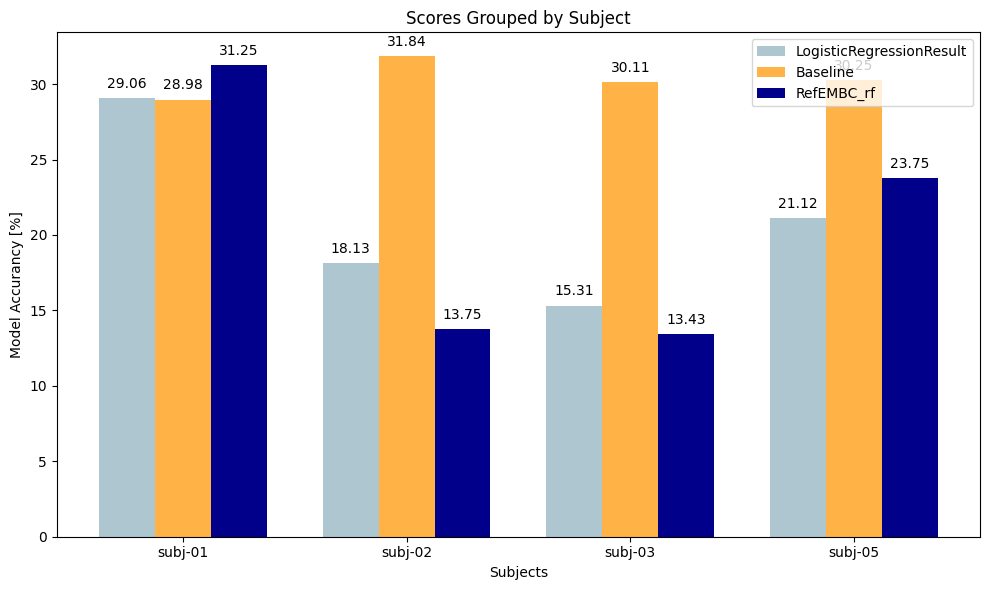

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Data for the table
data = {
    "Subjects": ["subj-01", "subj-02", "subj-03", "subj-05"],
    "Result": [29.06, 18.13, 15.31, 21.12],
    "Baseline": [28.98, 31.84, 30.11, 30.25],
    "RefEMBC_rf": [31.25, 13.75, 13.43, 23.75]
}

# Bar plot
x = np.arange(len(data["Subjects"]))
width = 0.25

plt.figure(figsize=(10, 6))
bars1 = plt.bar(x - width, data["Result"], width, label="LogisticRegressionResult", color='#aec6cf')  # Lighter blue
bars2 = plt.bar(x, data["Baseline"], width, label="Baseline", color='#ffb347')  # Lighter orange
bars3 = plt.bar(x + width, data["RefEMBC_rf"], width, label="RefEMBC_rf", color='#00008B')  # Light blue

# Add numbers on the bars
for bar in bars1:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, f'{bar.get_height():.2f}',
             ha='center', va='bottom')
for bar in bars2:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, f'{bar.get_height():.2f}',
             ha='center', va='bottom')
for bar in bars3:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, f'{bar.get_height():.2f}',
             ha='center', va='bottom')


# Add labels and legend
plt.xlabel("Subjects")
plt.ylabel("Model Accurancy [%]")
plt.title("Scores Grouped by Subject")
plt.xticks(x, data["Subjects"])
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()